DictWrapper 4
Mean uniform 333.41989326371095
Credible Interval 69 869
Mean powerlaw 178.54735317971574
Credible Interval 62 559


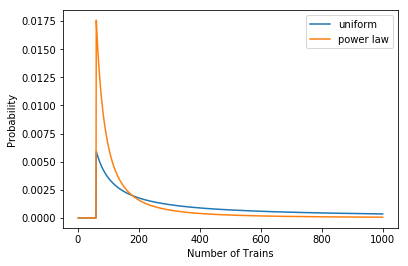

In [50]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter

class _DictWrapper(object):
    
    DEFAULT_LABEL = '_nolegend_'
    
    def __init__(self, obj=None, label=None):
        self.label = label if label is not None else self.DEFAULT_LABEL
        self.d = {}
        self.log = False
        if obj is None:
            return

        if isinstance(obj, (_DictWrapper, Cdf, Pdf)):
            self.label = label if label is not None else obj.label

        if isinstance(obj, dict):
            print("DictWrapper 1")
            self.d.update(obj.items())
        elif isinstance(obj, (_DictWrapper, Cdf, Pdf)):
            print("DictWrapper 2")
            self.d.update(obj.Items())
        elif isinstance(obj, pd.Series):
            print("DictWrapper 3")
            self.d.update(obj.value_counts().iteritems())
        else:
            # finally, treat it like a list
            print("DictWrapper 4")
            self.d.update(Counter(obj))

        if len(self) > 0 and isinstance(self, Pmf):
            self.Normalize()
        
    def Total(self):
        total = sum(self.d.values())
        return total
    
    def Mult(self, x, factor):
        self.d[x] = self.d.get(x,0) * factor
        
    def Values(self):
        return self.d.keys()

    def __len__(self):
        return len(self.d)

    def Items(self):
        return self.d.items()
    
    def SortedItems(self):
        """Gets a sorted sequence of (value, freq/prob) pairs.

        It items are unsortable, the result is unsorted.
        """
        def isnan(x):
            try:
                return math.isnan(x)
            except TypeError:
                return False

        if any([isnan(x) for x in self.Values()]):
            msg = 'Keys contain NaN, may not sort correctly.'
            logging.warning(msg)

        try:
            return sorted(self.d.items())
        except TypeError:
            return self.d.items()

    def Render(self, **options):
        """Generates a sequence of points suitable for plotting.

        Note: options are ignored

        Returns:
            tuple of (sorted value sequence, freq/prob sequence)
        """
        return zip(*self.SortedItems())

        
    def Print(self):
        """Prints the values and freqs/probs in ascending order."""
        for val, prob in self.SortedItems():
            print(val, prob)

    def Set(self,x,y=0):
        self.d[x] = y
        
class Cdf:
    pass

class Pdf:
    pass

class Pmf(_DictWrapper):
    
    def Normalize(self,fraction=1):
        if self.log:
            raise ValueError("Normalize: Pmf is under a log transform")
        total = self.Total()
        if total == 0:
            raise ValueError("Normalize: total probability is zero")
        factor = fraction / total
        for x in self.d:
            self.d[x] *= factor
        return total
    
    def Mean(self):
        return sum(p*x for x,p in self.Items())
    
    def Percentile(self, percentage):
        """Computes a percentile of a given Pmf.

        Note: this is not super efficient.  If you are planning
        to compute more than a few percentiles, compute the Cdf.

        percentage: float 0-100

        returns: value from the Pmf
        """
        p = percentage / 100
        total = 0
        for val, prob in sorted(self.Items()):
            total += prob
            if total >= p:
                return val

    
class Suite(Pmf):
    
    def Update(self,data):
        for hypo in self.Values():
            like = self.Likelihood(data,hypo)
            self.Mult(hypo,like)
        return self.Normalize()

    def Likelihood(self,data,hypo):
        raise UnimplementedMethodException()


class Train(Suite):

    def Likelihood(self,data,hypo):
        if hypo<data:
            return 0.0
        else:
            return 1.0/hypo


class Train_PowerLaw(Train):
    
    def __init__(self,hypos,alpha=1.0):
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo,hypo**(-alpha))
        self.Normalize()
        
        
def Chap3Page22():        
    hypos = range(1,1001)
    suite = Train(hypos)
    suite.Update(60)
    #suite.Print()
    print(suite.Mean())
    (val,freq) = suite.Render()
    plt.xlabel('Number of Trains')
    plt.ylabel('Probability')
    plt.plot(val,freq)
    plt.show
    
def Chap3Page23():
    for h in [501,1001,2001]:
        hypos = range(1,h)
        suite = Train(hypos)
        for data in [60,30,90]:
            suite.Update(data)
        print (suite.Mean())

def Chap3Page24(n,data):
    hypos = range(1,n)
    suite = Train(hypos)
    suite_pl = Train_PowerLaw(hypos)
    for d in data:
        suite.Update(d)
        suite_pl.Update(d)
    
    print("Mean uniform",suite.Mean())
    print("Credible Interval",suite.Percentile(5.0),suite.Percentile(95.0))
    print("Mean powerlaw", suite_pl.Mean())
    print("Credible Interval",suite_pl.Percentile(5.0),suite_pl.Percentile(95.0))
    
    plt.xlabel('Number of Trains')
    plt.ylabel('Probability')
    (val,freq) = suite.Render()
    plt.plot(val,freq)
    (val,freq) = suite_pl.Render()
    plt.plot(val,freq)
    plt.legend(['uniform','power law'])
    plt.show

def Chap3_PL_byObs(n,d,legend):
    hypos = range(1,n)
    suite_pl = Train_PowerLaw(hypos)
    
    plt.xlabel('Number of Trains')
    plt.ylabel('Probability')
    for i in range(len(d)):
        suite_pl.Update(d[i])
        (v,f) = suite_pl.Render()
        plt.plot(v,f)
    plt.legend(legend)
    plt.show()

def Chap3_Unif_byObs(n,d,legend):
    hypos = range(1,n)
    suite = Train(hypos)
    
    plt.xlabel('Number of Trains')
    plt.ylabel('Probability')
    for i in range(len(d)):
        suite.Update(d[i])
        (v,f) = suite.Render()
        plt.plot(v,f)
    plt.legend(legend)
    plt.show()

def Chap3_PL_byPrior(n,d,legend):
    
    plt.xlabel('Number of Trains')
    plt.ylabel('Probability')
    for i in range(len(n)):
        hypos = range(1,n[i])
        suite_pl = Train_PowerLaw(hypos)
        for datum in d:
            suite_pl.Update(datum)
        (v,f) = suite_pl.Render()
        plt.plot(v,f)
    plt.legend(legend)  
    plt.show()
    
def Chap3_Unif_byPrior(n,d,legend):
    
    plt.xlabel('Number of Trains')
    plt.ylabel('Probability')
    for i in range(len(n)):
        hypos = range(1,n[i])
        suite = Train(hypos)
        for datum in d:
            suite.Update(datum)
        (v,f) = suite.Render()
        plt.plot(v,f)
    plt.legend(legend)  
    plt.show()

Chap3Page24(1001,[60])
#Chap3Page24(501,[30,60,90])
#Chap3Page24(1001,[30,60,90])
#Chap3Page24(2001,[30,60,90])

#Chap3_PL_byObs(1001,[30,60,90],["30","30,60","30,60,90"])
#Chap3_Unif_byObs(1001,[30,60,90],["30","30,60","30,60,90"])

#Chap3_PL_byPrior([501,1001,2001],[30,60,90],["500","1000","2000"])
#Chap3_Unif_byPrior([501,1001,2001],[30,60,90],["500","1000","2000"])
